## Business Problem:

U.S. Bureau of Labour Statistics releases Current Employment Statistics monthly. Let’s say you are an official working at the U.S. Bureau of Labour Statistics and you are looking to estimate the number of unemployed people.

 
The dataset contains information on the monthly unemployment rate. It has two columns, ‘DATE’ (the date of measuring the unemployment rate) and ‘UNRATE’ (represents the number of unemployed as a percentage of the labour force).

We have to forecast the unemployment rate using the different Auto Regressive forecasting techniques. The overall data you have is for 867 months. 

#### Importing necessary libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

##### Reading the dataset

In [2]:
unrate = pd.read_csv("UNRATE.csv", header=None)
unrate.head()

,0,1
0,01-01-1948,3.4
1,01-02-1948,3.8
2,01-03-1948,4.0
3,01-04-1948,3.9
4,01-05-1948,3.5


In [3]:
## Renaming the column headers for ease of access and changing datatype of Month to dateTime

unrate.columns = ['Month', 'Rate']
unrate['Month'] = pd.to_datetime(unrate['Month'], format = '%d-%m-%Y')

In [4]:
## Making Month as index

unrate.set_index('Month', inplace=True)
unrate.head()

,Rate
Month,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


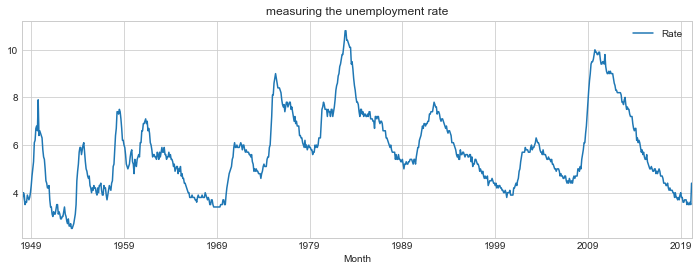

In [5]:
## Plotting the curve

plt.style.use('seaborn-whitegrid')
unrate.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('measuring the unemployment rate')
plt.show(block=False)

### Time series Decomposition

##### Additive Seasonal Decomposition

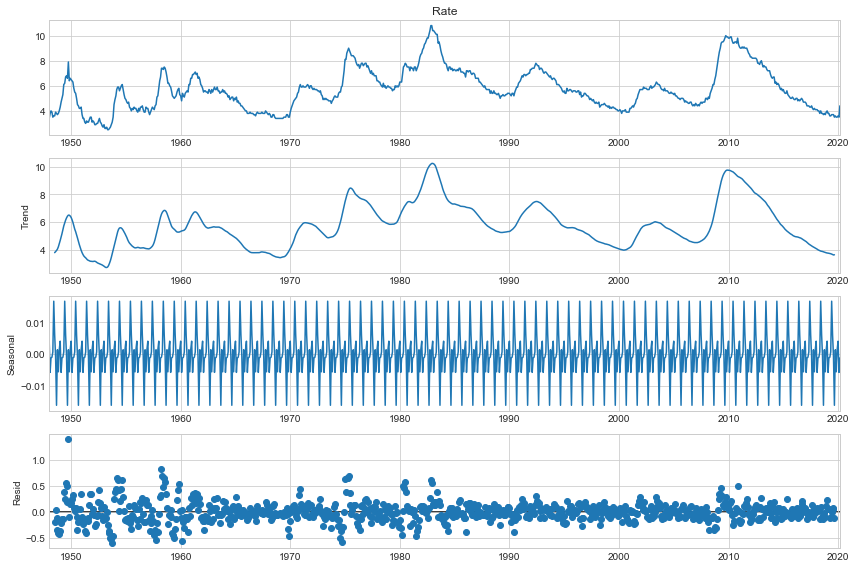

In [6]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(unrate.Rate, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

##### Multiplicative Seasonal Decomposition

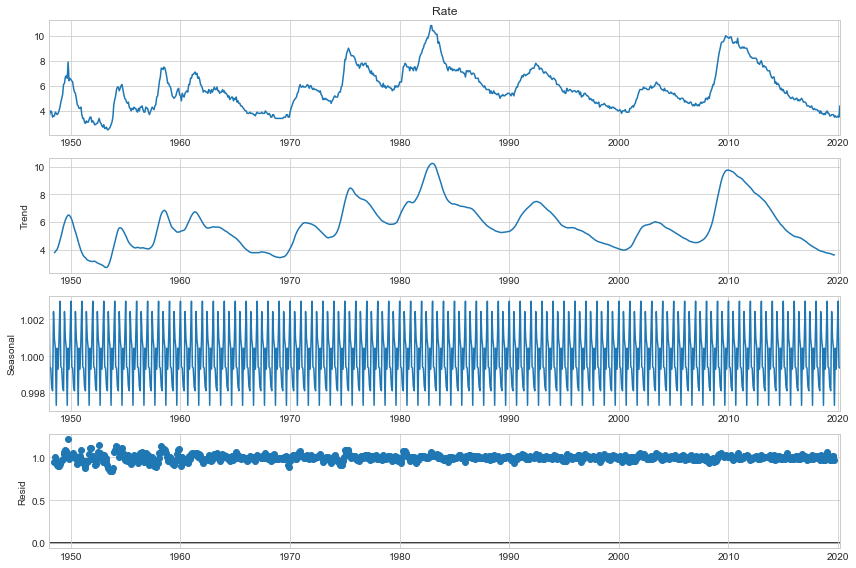

In [7]:
decomposition = sm.tsa.seasonal_decompose(unrate.Rate, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

## Build and evaluate time series forecast

In [8]:
## Dividing into test and train

train_len = 612
train = unrate[:train_len]
test = unrate[train_len:]

print("Train Shape : {}".format(train.shape))
print("Test Shape : {}".format(test.shape))


Train Shape : (612, 1)
Test Shape : (255, 1)


#### Naive method

In [9]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Rate'][train_len-1]

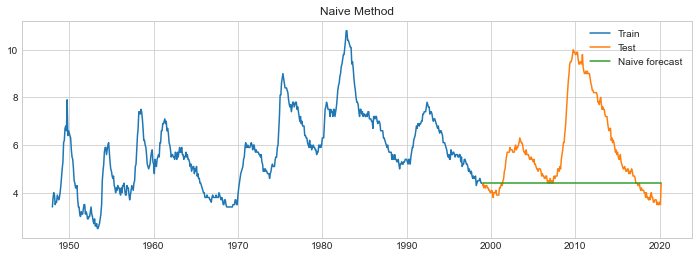

In [10]:
plt.figure(figsize=(12,4))
plt.plot(train['Rate'], label='Train')
plt.plot(test['Rate'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

In [11]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Rate'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Rate']-y_hat_naive['naive_forecast'])/test['Rate'])*100,2)
acc = 100 - mape
results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse], 'Accuracy':[acc]})
results = results[['Method', 'RMSE', 'MAPE','Accuracy']]
results

,Method,RMSE,MAPE,Accuracy
0,Naive method,2.27,22.5,77.5


#### Simple Average Method

In [12]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Rate'].mean()

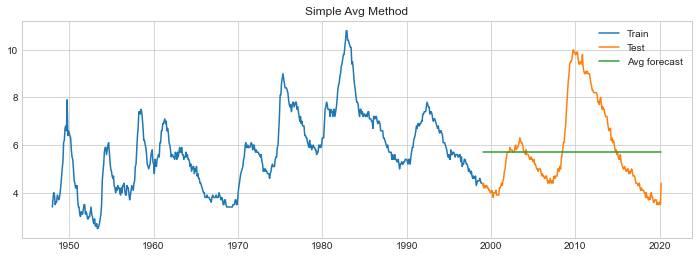

In [13]:
plt.figure(figsize=(12,4))
plt.plot(train['Rate'], label='Train')
plt.plot(test['Rate'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Avg forecast')
plt.legend(loc='best')
plt.title('Simple Avg Method')
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Rate'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Rate']-y_hat_avg['avg_forecast'])/test['Rate'])*100,2)
acc = 100 - mape
temp_results = pd.DataFrame({'Method':['Simple Avg method'], 'MAPE': [mape], 'RMSE': [rmse], 'Accuracy':[acc]})
results = pd.concat([results,temp_results])
results = results[['Method', 'RMSE', 'MAPE','Accuracy']]
results

,Method,RMSE,MAPE,Accuracy
0,Naive method,2.27,22.50,77.50
0,Simple Avg method,1.80,24.82,75.18


#### Simple Moving Average

In [15]:
y_hat_sma = unrate.copy()
ma_window = 12
y_hat_sma['sma_forecast'] = unrate['Rate'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

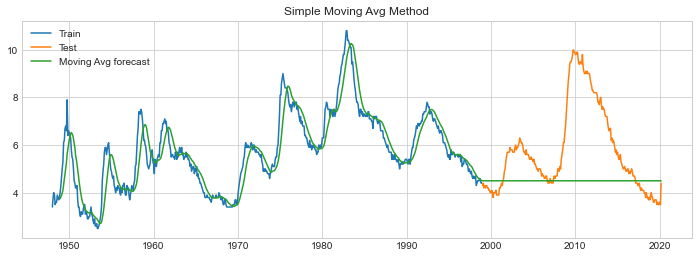

In [16]:
plt.figure(figsize=(12,4))
plt.plot(train['Rate'], label='Train')
plt.plot(test['Rate'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Moving Avg forecast')
plt.legend(loc='best')
plt.title('Simple Moving Avg Method')
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Rate'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Rate']-y_hat_sma['sma_forecast'][train_len:])/test['Rate'])*100,2)
acc = 100 - mape
temp_results = pd.DataFrame({'Method':['Simple Moving Avg method'], 'MAPE': [mape], 'RMSE': [rmse], 'Accuracy':[acc]})
results = pd.concat([results,temp_results])
results = results[['Method', 'RMSE', 'MAPE','Accuracy']]
results

,Method,RMSE,MAPE,Accuracy
0,Naive method,2.27,22.50,77.50
0,Simple Avg method,1.80,24.82,75.18
0,Simple Moving Avg method,2.21,21.99,78.01


#### Simple exponential smoothing

In [18]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Rate'])
model_fit = model.fit(smoothing_level=0.2,optimized=False)
model_fit.params

y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(len(test))

A:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


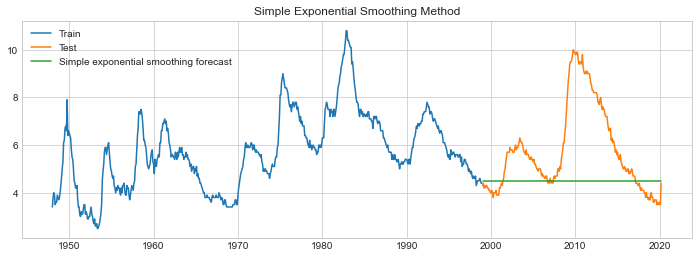

In [19]:
plt.figure(figsize=(12,4))
plt.plot(train['Rate'], label='Train')
plt.plot(test['Rate'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Rate'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Rate']-y_hat_ses['ses_forecast'])/test['Rate'])*100,2)
acc = 100 - mape
temp_results = pd.DataFrame({'Method':['Simple Exponential Smoothing method'], 'MAPE': [mape], 'RMSE': [rmse], 'Accuracy':[acc]})
results = pd.concat([results,temp_results])
results = results[['Method', 'RMSE', 'MAPE','Accuracy']]
results

,Method,RMSE,MAPE,Accuracy
0,Naive method,2.27,22.50,77.50
0,Simple Avg method,1.80,24.82,75.18
0,Simple Moving Avg method,2.21,21.99,78.01
0,Simple Exponential Smoothing method,2.21,22.01,77.99


#### Holt's Method

In [21]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['Rate']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(smoothing_level=0.2, smoothing_slope=0.01, optimized=False)
print(model_fit.params)

y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.2, 'smoothing_trend': 0.01, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 3.4, 'initial_trend': 0.3999999999999999, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


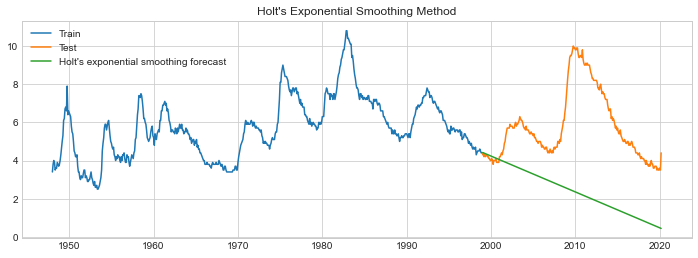

In [22]:
plt.figure(figsize=(12,4))
plt.plot( train['Rate'], label='Train')
plt.plot(test['Rate'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

In [23]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Rate'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Rate']-y_hat_holt['holt_forecast'])/test['Rate'])*100,2)
acc = 100 - mape
temp_results = pd.DataFrame({'Method':['Holt\'s method'], 'MAPE': [mape], 'RMSE': [rmse], 'Accuracy':[acc]})
results = pd.concat([results,temp_results])
results = results[['Method', 'RMSE', 'MAPE','Accuracy']]
results

,Method,RMSE,MAPE,Accuracy
0,Naive method,2.27,22.50,77.50
0,Simple Avg method,1.80,24.82,75.18
0,Simple Moving Avg method,2.21,21.99,78.01
0,Simple Exponential Smoothing method,2.21,22.01,77.99
0,Holt's method,3.99,55.15,44.85


#### Holt Winter's additive method

In [24]:
model = ExponentialSmoothing(np.asarray(train['Rate']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)

y_hat_hwa = test.copy()
y_hat_hwa['hw_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.8100092098916375, 'smoothing_trend': 0.34654623410948643, 'smoothing_seasonal': 5.9659780632620474e-15, 'damping_trend': nan, 'initial_level': 5.350329047641033, 'initial_trend': 0.11373264126523026, 'initial_seasons': array([-1.97442755, -1.98112509, -1.96793451, -1.9701991 , -1.97617842,
       -1.96622834, -1.97367986, -1.98677185, -1.99176822, -1.97299102,
       -1.98730039, -1.97589044]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


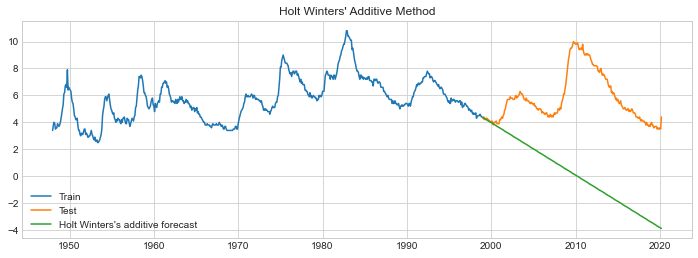

In [25]:
plt.figure(figsize=(12,4))
plt.plot( train['Rate'], label='Train')
plt.plot(test['Rate'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

In [26]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Rate'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Rate']-y_hat_hwa['hw_forecast'])/test['Rate'])*100,2)
acc = 100 - mape
temp_results = pd.DataFrame({'Method':['Holt Winters\' Additive Method'], 'MAPE': [mape], 'RMSE': [rmse], 'Accuracy':[acc]})
results = pd.concat([results,temp_results])
results = results[['Method', 'RMSE', 'MAPE','Accuracy']]
results

,Method,RMSE,MAPE,Accuracy
0,Naive method,2.27,22.50,77.50
0,Simple Avg method,1.80,24.82,75.18
0,Simple Moving Avg method,2.21,21.99,78.01
0,Simple Exponential Smoothing method,2.21,22.01,77.99
0,Holt's method,3.99,55.15,44.85
0,Holt Winters' Additive Method,6.32,95.94,4.06


#### Holt Winter's additive method

In [27]:
model = ExponentialSmoothing(np.asarray(train['Rate']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)

y_hat_hwm = test.copy()
y_hat_hwm['hwm_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.8093882348816599, 'smoothing_trend': 0.3472346289698033, 'smoothing_seasonal': 3.021809724297182e-17, 'damping_trend': nan, 'initial_level': 3.6799221553166337, 'initial_trend': 0.12222632788483122, 'initial_seasons': array([0.91774859, 0.91775653, 0.91968947, 0.91998999, 0.91969687,
       0.92025749, 0.91853528, 0.91624551, 0.91541714, 0.91987364,
       0.91705149, 0.9190464 ]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


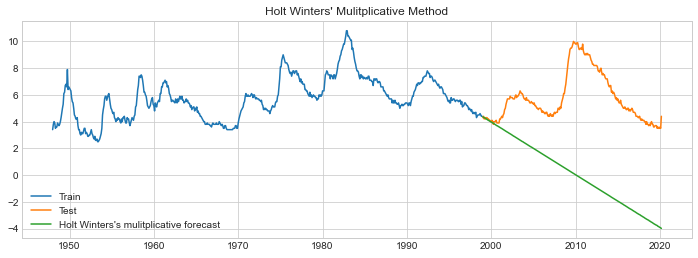

In [28]:
plt.figure(figsize=(12,4))
plt.plot( train['Rate'], label='Train')
plt.plot(test['Rate'], label='Test')
plt.plot(y_hat_hwm['hwm_forecast'], label='Holt Winters\'s mulitplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Mulitplicative Method')
plt.show()

In [29]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Rate'], y_hat_hwm['hwm_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Rate']-y_hat_hwm['hwm_forecast'])/test['Rate'])*100,2)
acc = 100 - mape
temp_results = pd.DataFrame({'Method':['Holt Winters\' Mulitplicative Method'], 'MAPE': [mape], 'RMSE': [rmse], 'Accuracy':[acc]})
results = pd.concat([results,temp_results])
results = results[['Method', 'RMSE', 'MAPE','Accuracy']]
results

,Method,RMSE,MAPE,Accuracy
0,Naive method,2.27,22.50,77.50
0,Simple Avg method,1.80,24.82,75.18
0,Simple Moving Avg method,2.21,21.99,78.01
0,Simple Exponential Smoothing method,2.21,22.01,77.99
0,Holt's method,3.99,55.15,44.85
0,Holt Winters' Additive Method,6.32,95.94,4.06
0,Holt Winters' Mulitplicative Method,6.38,96.89,3.11


### Auto Regressive methods

#### Augmented Dickey-Fuller (ADF) test

In [30]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(unrate['Rate'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -3.143963
Critical Values @ 0.05: -2.86
p-value: 0.023466


#### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [31]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(unrate['Rate'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.464446
Critical Values @ 0.05: 0.46
p-value: 0.049674


#### Box Cox transformation to make variance constant

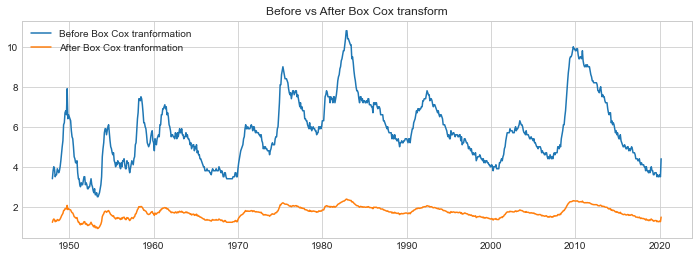

In [32]:
from scipy.stats import boxcox
unrate_boxcox = pd.Series(boxcox(unrate['Rate'], lmbda=0), index = unrate.index)

plt.figure(figsize=(12,4))
plt.plot(unrate, label='Before Box Cox tranformation')
plt.plot(unrate_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('Before vs After Box Cox transform')
plt.show()

#### Differencing to remove trend

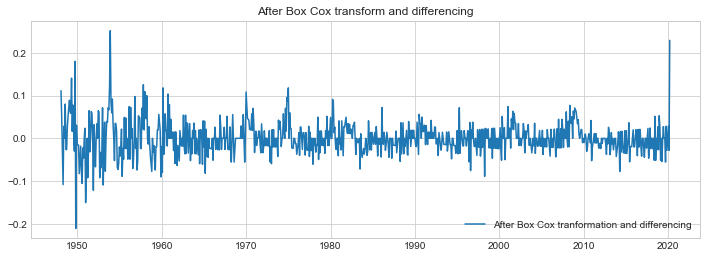

In [33]:
unrate_boxcox_diff = pd.Series(unrate_boxcox - unrate_boxcox.shift(), unrate.index)
plt.figure(figsize=(12,4))
plt.plot(unrate_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [34]:
unrate_boxcox_diff.dropna(inplace=True)

In [35]:
unrate_boxcox_diff.tail()

Month
2019-11-01   -0.028171
2019-12-01    0.000000
2020-01-01    0.028171
2020-02-01   -0.028171
2020-03-01    0.228842
dtype: float64

#### Augmented Dickey-Fuller (ADF) test

In [36]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(unrate_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -8.918955
Critical Values @ 0.05: -2.86
p-value: 0.000000


#### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [37]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(unrate_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.062761
Critical Values @ 0.05: 0.46
p-value: 0.100000


A:\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Clearly the time series is now stationary

#### Autocorrelation function (ACF)

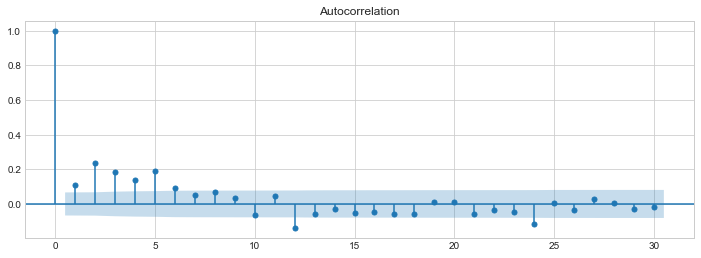

In [38]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(unrate_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

#### Partial autocorrelation function (PACF)

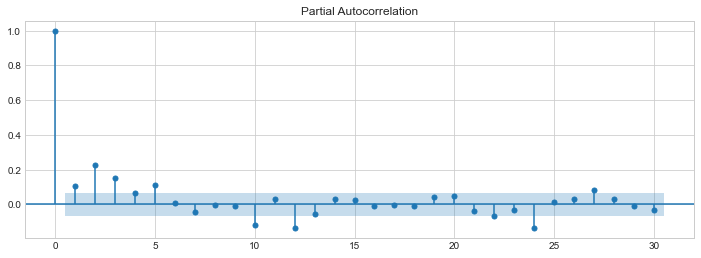

In [39]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(unrate_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

In [40]:
train_boxcox = unrate_boxcox[:train_len]
test_boxcox = unrate_boxcox[train_len:]
train_boxcox_diff = unrate_boxcox_diff[:train_len-1]
test_boxcox_diff = unrate_boxcox_diff[train_len-1:]

#### Auto regression method (AR)

In [41]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_boxcox_diff, order=(12, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

A:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


const       0.000466
ar.L1.y     0.060691
ar.L2.y     0.161198
ar.L3.y     0.118646
ar.L4.y     0.090456
ar.L5.y     0.107079
ar.L6.y     0.008286
ar.L7.y    -0.029412
ar.L8.y     0.032450
ar.L9.y     0.006198
ar.L10.y   -0.124660
ar.L11.y    0.047125
ar.L12.y   -0.148533
dtype: float64


In [42]:
y_hat_ar = unrate_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(unrate_boxcox_diff.index.min(), unrate_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(unrate_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

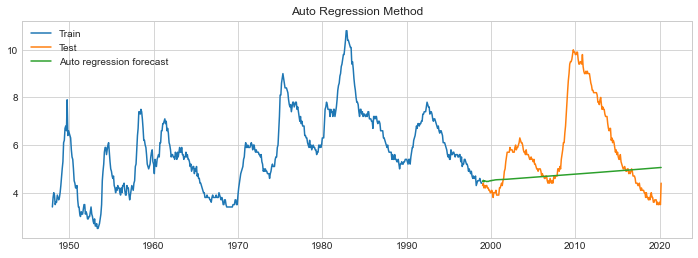

In [43]:
plt.figure(figsize=(12,4))
plt.plot(train['Rate'], label='Train')
plt.plot(test['Rate'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

In [44]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Rate'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Rate']-y_hat_ar['ar_forecast'][test.index.min():])/test['Rate'])*100,2)
acc = 100 - mape
temp_results = pd.DataFrame({'Method':['Auto Regression Method'], 'MAPE': [mape], 'RMSE': [rmse], 'Accuracy':[acc]})
results = pd.concat([results,temp_results])
results = results[['Method', 'RMSE', 'MAPE','Accuracy']]
results

,Method,RMSE,MAPE,Accuracy
0,Naive method,2.27,22.50,77.50
0,Simple Avg method,1.80,24.82,75.18
0,Simple Moving Avg method,2.21,21.99,78.01
0,Simple Exponential Smoothing method,2.21,22.01,77.99
0,Holt's method,3.99,55.15,44.85
0,Holt Winters' Additive Method,6.32,95.94,4.06
0,Holt Winters' Mulitplicative Method,6.38,96.89,3.11
0,Auto Regression Method,2.07,21.50,78.50


In [45]:
y_hat_ar.head(21)

Month
1948-02-01 00:00:00    0.111226
1948-03-01 00:00:00    0.051293
1948-04-01 00:00:00   -0.025318
1948-05-01 00:00:00   -0.108214
1948-06-01 00:00:00    0.028171
1948-07-01 00:00:00         0.0
1948-08-01 00:00:00    0.080043
1948-09-01 00:00:00   -0.025975
1948-10-01 00:00:00   -0.026668
1948-11-01 00:00:00    0.026668
1948-12-01 00:00:00    0.051293
1949-01-01 00:00:00    0.072321
1949-02-01 00:00:00    0.088947
1949-03-01 00:00:00    0.061875
1949-04-01 00:00:00    0.058269
1949-05-01 00:00:00    0.140582
1949-06-01 00:00:00    0.016261
1949-07-01 00:00:00    0.077558
1949-08-01 00:00:00    0.014815
1949-09-01 00:00:00   -0.029853
1949-10-01 00:00:00    0.179793
dtype: object

#### Moving average method (MA)

In [46]:
model = ARIMA(train_boxcox_diff, order=(0, 0, 5)) 
model_fit = model.fit()
print(model_fit.params)

A:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


const      0.000507
ma.L1.y    0.055504
ma.L2.y    0.181882
ma.L3.y    0.123451
ma.L4.y    0.099834
ma.L5.y    0.151700
dtype: float64


In [47]:
y_hat_ma = unrate_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(unrate_boxcox_diff.index.min(), unrate_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(unrate_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

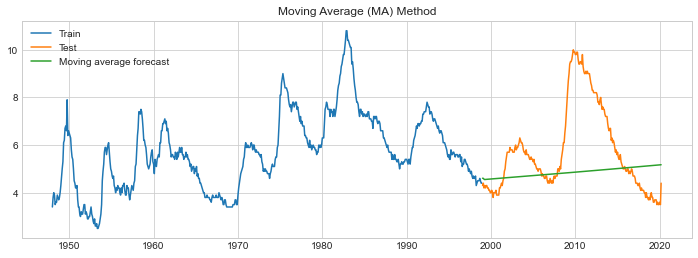

In [48]:
plt.figure(figsize=(12,4))
plt.plot(unrate['Rate'][:train_len], label='Train')
plt.plot(unrate['Rate'][train_len:], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving average forecast')
plt.legend(loc='best')
plt.title('Moving Average (MA) Method')
plt.show()

In [49]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Rate'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Rate']-y_hat_ma['ma_forecast'][test.index.min():])/test['Rate'])*100,2)
acc = 100 - mape
temp_results = pd.DataFrame({'Method':['Moving Average (MA) Method'], 'MAPE': [mape], 'RMSE': [rmse], 'Accuracy':[acc]})
results = pd.concat([results,temp_results])
results = results[['Method', 'RMSE', 'MAPE','Accuracy']]
results

,Method,RMSE,MAPE,Accuracy
0,Naive method,2.27,22.50,77.50
0,Simple Avg method,1.80,24.82,75.18
0,Simple Moving Avg method,2.21,21.99,78.01
0,Simple Exponential Smoothing method,2.21,22.01,77.99
0,Holt's method,3.99,55.15,44.85
0,Holt Winters' Additive Method,6.32,95.94,4.06
0,Holt Winters' Mulitplicative Method,6.38,96.89,3.11
0,Auto Regression Method,2.07,21.50,78.50
0,Moving Average (MA) Method,2.03,21.60,78.40


In [50]:
y_hat_ma.head(10)

Month
1948-02-01 00:00:00    0.111226
1948-03-01 00:00:00    0.051293
1948-04-01 00:00:00   -0.025318
1948-05-01 00:00:00   -0.108214
1948-06-01 00:00:00    0.028171
1948-07-01 00:00:00         0.0
1948-08-01 00:00:00    0.080043
1948-09-01 00:00:00   -0.025975
1948-10-01 00:00:00   -0.026668
1948-11-01 00:00:00    0.026668
dtype: object

#### Auto regressive integrated moving average (ARIMA)

In [51]:
model = ARIMA(train_boxcox, order=(12, 1, 5))
model_fit = model.fit()
print(model_fit.params)

A:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
A:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


const         0.000447
ar.L1.D.y    -0.092093
ar.L2.D.y     0.664052
ar.L3.D.y     0.483227
ar.L4.D.y    -0.459265
ar.L5.D.y    -0.600542
ar.L6.D.y     0.048077
ar.L7.D.y     0.049874
ar.L8.D.y     0.098509
ar.L9.D.y     0.134359
ar.L10.D.y   -0.047275
ar.L11.D.y    0.009460
ar.L12.D.y   -0.073520
ma.L1.D.y     0.121922
ma.L2.D.y    -0.506370
ma.L3.D.y    -0.358752
ma.L4.D.y     0.512516
ma.L5.D.y     0.670651
dtype: float64


A:\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
A:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [52]:
y_hat_arima = unrate_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(unrate_boxcox_diff.index.min(), unrate_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(unrate_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

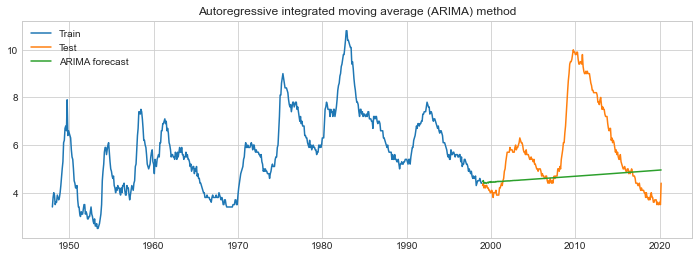

In [53]:
plt.figure(figsize=(12,4))
plt.plot(train['Rate'], label='Train')
plt.plot(test['Rate'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

In [54]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Rate'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Rate']-y_hat_arima['arima_forecast'][test.index.min():])/test['Rate'])*100,2)
acc = 100 - mape
temp_results = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA) Method'], 'MAPE': [mape], 'RMSE': [rmse], 'Accuracy':[acc]})
results = pd.concat([results,temp_results])
results = results[['Method', 'RMSE', 'MAPE','Accuracy']]
results

,Method,RMSE,MAPE,Accuracy
0,Naive method,2.27,22.50,77.50
0,Simple Avg method,1.80,24.82,75.18
0,Simple Moving Avg method,2.21,21.99,78.01
0,Simple Exponential Smoothing method,2.21,22.01,77.99
0,Holt's method,3.99,55.15,44.85
0,Holt Winters' Additive Method,6.32,95.94,4.06
0,Holt Winters' Mulitplicative Method,6.38,96.89,3.11
0,Auto Regression Method,2.07,21.50,78.50
0,Moving Average (MA) Method,2.03,21.60,78.40
0,Autoregressive integrated moving average (ARIM...,2.11,21.65,78.35


#### Seasonal auto regressive integrated moving average (SARIMA)

In [55]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_boxcox, order=(2, 1, 4), seasonal_order=(2, 1, 4, 12)) 
model_fit = model.fit()
print(model_fit.params)

A:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
A:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
A:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ar.L1       0.592397
ar.L2       0.125309
ma.L1      -0.555794
ma.L2      -0.006937
ma.L3       0.071346
ma.L4       0.052222
ar.S.L12   -0.939194
ar.S.L24   -0.514578
ma.S.L12   -0.276323
ma.S.L24   -0.538171
ma.S.L36   -0.402343
ma.S.L48    0.268682
sigma2      0.001495
dtype: float64


In [56]:
y_hat_sarima = unrate_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(unrate_boxcox_diff.index.min(), unrate_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

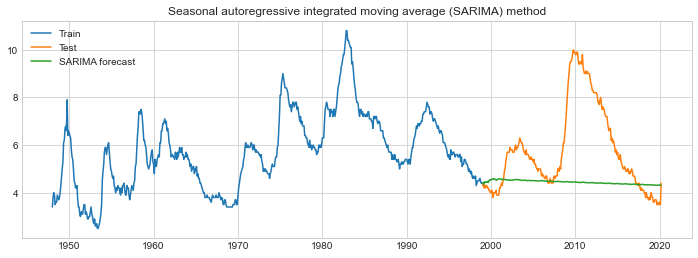

In [57]:
plt.figure(figsize=(12,4))
plt.plot(train['Rate'], label='Train')
plt.plot(test['Rate'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

In [58]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Rate'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Rate']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Rate'])*100,2)
acc = 100 - mape
temp_results = pd.DataFrame({'Method':['Seasonal Autoregressive integrated moving average (SARIMA) Method'], 'MAPE': [mape], 'RMSE': [rmse], 'Accuracy':[acc]})
results = pd.concat([results,temp_results])
results = results[['Method', 'RMSE', 'MAPE','Accuracy']]
results

,Method,RMSE,MAPE,Accuracy
0,Naive method,2.27,22.50,77.50
0,Simple Avg method,1.80,24.82,75.18
0,Simple Moving Avg method,2.21,21.99,78.01
0,Simple Exponential Smoothing method,2.21,22.01,77.99
0,Holt's method,3.99,55.15,44.85
0,Holt Winters' Additive Method,6.32,95.94,4.06
0,Holt Winters' Mulitplicative Method,6.38,96.89,3.11
0,Auto Regression Method,2.07,21.50,78.50
0,Moving Average (MA) Method,2.03,21.60,78.40
0,Autoregressive integrated moving average (ARIM...,2.11,21.65,78.35
